In [3]:
import numpy as np
import cv2
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import glob
import os
import sys
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import svm as svm_sk
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize

# Preprocessing Training data
fruit_images_t = []
labels_t = [] 
for fruit_dir_path in glob.glob("fruits-360/Training/*"):
    fruit_label = fruit_dir_path.split("\\")[-1]
    for image_path in glob.glob(os.path.join(fruit_dir_path, "*.jpg")):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        
        image = cv2.resize(image, (45, 45))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        fruit_images_t.append(image)
        labels_t.append(fruit_label)
fruit_images_t = np.array(fruit_images_t)
labels_t = np.array(labels_t)

# Preprocessing Validation data
fruit_images_v = []
labels_v = [] 
for fruit_dir_path in glob.glob("fruits-360/Validation/*"):
    fruit_label = fruit_dir_path.split("\\")[-1]
    for image_path in glob.glob(os.path.join(fruit_dir_path, "*.jpg")):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)

        image = cv2.resize(image, (45, 45))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        fruit_images_v.append(image)
        labels_v.append(fruit_label)
fruit_images_v = np.array(fruit_images_v)
labels_v = np.array(labels_v)

# Create dicts/arrays for Training Data
names_t = np.unique(labels_t)
ids_t = [k for k in range(0, len(names_t))]
name_id_t = list(zip(names_t, ids_t))
id_to_name_t = {id: name for (name, id) in name_id_t}
name_to_id_t = {name: id for (name, id) in name_id_t}
label_ids_t = np.array([name_to_id_t[x] for x in labels_t])

# Create dicts/arrays for Validation data
names_v = np.unique(labels_v)
ids_v = [k for k in range(len(names_v))]
id_name_v = list(zip(ids_v, names_v))
name_to_id_v = {name: id for (id, name) in id_name_v}
id_to_name_v = {id: name for (id, name) in id_name_v}
label_ids_v = np.array([name_to_id_v[x] for x in labels_v])

#End of preprocessing stage

In [2]:
# PCA Cell
# Scale Training data and then run PCA on it
scaler = StandardScaler()
scaled_images = scaler.fit_transform([im.flatten() for im in fruit_images_t])
pca = PCA(n_components=80)
pca_result_t = pca.fit_transform(scaled_images)

# Split training set
X_train, X_test, y_train, y_test = train_test_split(pca_result_t, label_ids_t, test_size=0.6)

# Scale Validation Data and run PCA on it
images_scaled = scaler.transform([im.flatten() for im in fruit_images_v])
pca_result_v = pca.transform(images_scaled)

In [18]:
print(fruit_images_t[0])

[[[254 255 255]
  [254 255 255]
  [255 255 255]
  ...
  [255 253 254]
  [255 255 255]
  [255 255 255]]

 [[254 255 255]
  [254 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [254 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[252 255 251]
  [255 253 254]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]


In [4]:
# Manual extraction of features from images

def color_features(img):
    gray_img_f = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).flatten() # make grayscale and invert b/w
    img_f = img.reshape((img.shape[0]*img.shape[1],3))
    mean_rgb = np.zeros(3)
    counts=0
    for k in range(img_f.shape[0]):
        if gray_img_f[k] <= 240: # somewhat arbitrary
            mean_rgb += img_f[k]
            counts += 1
            
    mean_rgb = mean_rgb / counts
    
    # Now lets find color variance
    variance = np.sum(np.square(img_f-mean_rgb),axis=0)
    return list(mean_rgb) + list(variance)
    
def shape_features(img):
    gray_img = 255 - cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # make grayscale and invert b/w
    thresh = cv2.adaptiveThreshold(gray_img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY,11,2) # make image binary
    im2, cnt, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE) # Find connected components
    max_cnt = cnt[np.argmax([len(x) for x in cnt])] # Use the biggest component
    
    # Compute key features
    M = cv2.moments(max_cnt)
    ellipse = cv2.fitEllipse(max_cnt)
    min_max_ratio = min(ellipse[1][0] / ellipse[1][1],
                      ellipse[1][1] / ellipse[1][0])
    area_covered = M['m00'] / (ellipse[1][0] * ellipse[1][1])
    perimeter_to_area = M['m00'] / cv2.arcLength(max_cnt,False)
    
    return [min_max_ratio, area_covered, perimeter_to_area]
    
def get_features_from_img(img):
    return color_features(img) + shape_features(img)

def imgs_to_features(imgs):
    N = imgs.shape[0]
    features = np.zeros((N,9))
    for i in range(N):
        features[i,:] = get_features_from_img(imgs[i])
    return features

custom_features_t = imgs_to_features(fruit_images_t)
custom_features_v = imgs_to_features(fruit_images_v)

Accuracy with SVM on X_test_c: 92.708333


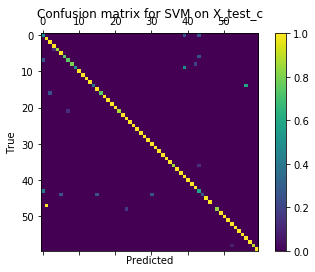

In [39]:
# Scaled custom features
custom_scaler = StandardScaler()
cft = custom_scaler.fit_transform(custom_features_t)
cfv = custom_scaler.transform(custom_features_v)

# Split custom training set
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(cft, label_ids_t, test_size=0.01)

# Train SVM on custom features
svm_c = svm_sk.SVC(kernel='poly',degree=1)
svm_c = svm_c.fit(X_train_c, y_train_c)
svm_test_predictions_c = svm_c.predict(X_test_c)

# Compute accuracy scores
svm_precision_t_c = accuracy_score(svm_test_predictions_c, y_test_c) * 100
print("Accuracy with SVM on X_test_c: {0:.6f}".format(svm_precision_t_c))

# Compute Confusion Matrix for SVM on X_test_c
cm_svm_t_c = confusion_matrix(y_test_c, svm_test_predictions_c)
cm_svm_t_c = normalize(cm_svm_t_c, axis=1, norm='l1')

# Plot confusion matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm_svm_t_c)
plt.title('Confusion matrix for SVM on X_test_c')
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Accuracy with SVM on (custom features) Validation data: 91.347048


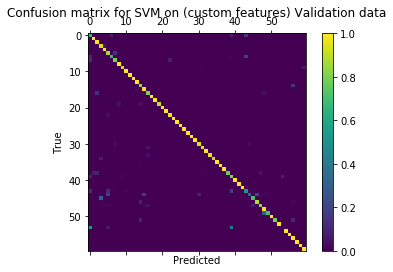

In [40]:
# Predict with SVM on (custom features) Validation data
svm_prediction_v_c = svm_c.predict(cfv)

# Compute accuracy scores for all classifiers
svm_precision_v_c = accuracy_score(svm_prediction_v_c, label_ids_v) * 100

print("Accuracy with SVM on (custom features) Validation data: {0:.6f}".format(svm_precision_v_c))

# Compute confusion matrices for all classifiers
cm_svm_v_c = confusion_matrix(label_ids_v, svm_prediction_v_c)
cm_svm_v_c = normalize(cm_svm_v_c, axis=1, norm='l1')

# Plot both confusion matrices (separate windows)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm_svm_v_c)
plt.title('Confusion matrix for SVM on (custom features) Validation data')
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Accuracy with RF on X_test_c: 99.652778


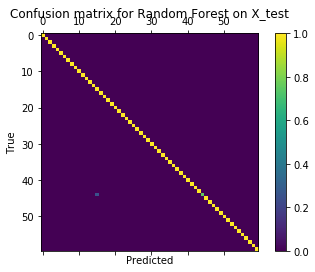

In [42]:
# Train Random Forest (on custom features)
forest_c = RandomForestClassifier(n_estimators=100)
forest_c = forest_c.fit(X_train_c, y_train_c)

# Make predictions w/ both classifiers
forest_test_predictions_t_c = forest_c.predict(X_test_c)

# Compute accuracy scores
forest_precision_t_c = accuracy_score(forest_test_predictions_t_c, y_test_c) * 100 
print("Accuracy with RF on X_test_c: {0:.6f}".format(forest_precision_t_c))

# Compute Confusion Matrices for both classifiers
cm_forest_t_c = confusion_matrix(y_test_c, forest_test_predictions_t_c)
cm_forest_t_c = normalize(cm_forest_t_c, axis=1, norm='l1')

# Plot both confusion matrices (separate windows)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm_forest_t_c)
plt.title('Confusion matrix for Random Forest on X_test')
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Accuracy with forest on (custom features) Validation data: 93.735139


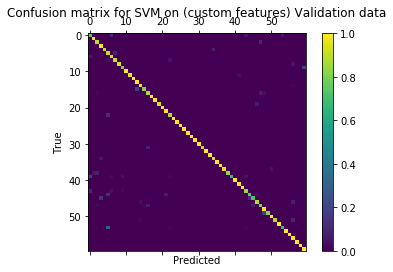

In [43]:
# Predict with SVM on (custom features) Validation data
forest_prediction_v_c = forest_c.predict(cfv)

# Compute accuracy scores for all classifiers
forest_precision_v_c = accuracy_score(forest_prediction_v_c, label_ids_v) * 100

print("Accuracy with forest on (custom features) Validation data: {0:.6f}".format(forest_precision_v_c))

# Compute confusion matrices for all classifiers
cm_forest_v_c = confusion_matrix(label_ids_v, forest_prediction_v_c)
cm_forest_v_c = normalize(cm_forest_v_c, axis=1, norm='l1')

# Plot both confusion matrices (separate windows)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm_forest_v_c)
plt.title('Confusion matrix for SVM on (custom features) Validation data')
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Accuracy with SVM on X_test: 99.866605


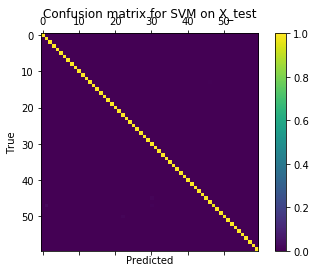

In [108]:
# Train SVM
svm = svm_sk.SVC(C=1.0, kernel='poly')
svm = svm.fit(X_train, y_train)

# Make predictions w/ both classifiers
svm_test_predictions = svm.predict(X_test)

# Compute accuracy scores
svm_precision_t = accuracy_score(svm_test_predictions, y_test) * 100
print("Accuracy with SVM on X_test: {0:.6f}".format(svm_precision_t))

# Compute Confusion Matrices for both classifiers
cm_svm_t = confusion_matrix(y_test, svm_test_predictions)
cm_svm_t = normalize(cm_svm_t, axis=1, norm='l1')

# Plot both confusion matrices (separate windows)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm_svm_t)
plt.title('Confusion matrix for SVM on X_test')
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Accuracy with SVM on Validation data: 93.745477


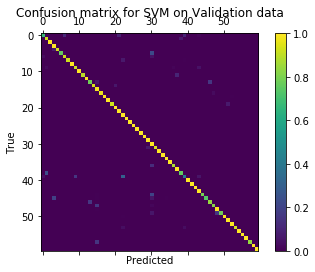

In [15]:
# Predict on with all classifiers Validation data
svm_prediction_v = svm.predict(pca_result_v)

# Compute accuracy scores for all classifiers
svm_precision_v = accuracy_score(svm_prediction_v, label_ids_v) * 100

print("Accuracy with SVM on Validation data: {0:.6f}".format(svm_precision_v))

# Compute confusion matrices for all classifiers
cm_svm_v = confusion_matrix(label_ids_v, svm_prediction_v)
cm_svm_v = normalize(cm_svm_v, axis=1, norm='l1')

# Plot both confusion matrices (separate windows)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm_svm_v)
plt.title('Confusion matrix for SVM on Validation data')
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Accuracy with RF on X_test: 98.538453


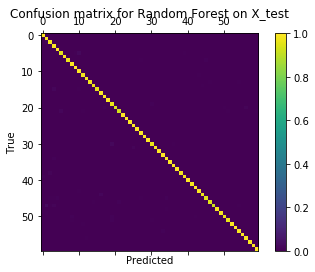

In [14]:
# Train Random Forest
forest = RandomForestClassifier(n_estimators=10)
forest = forest.fit(X_train, y_train)

# Make predictions w/ both classifiers
forest_test_predictions = forest.predict(X_test)

# Compute accuracy scores
forest_precision_t = accuracy_score(forest_test_predictions, y_test) * 100 
print("Accuracy with RF on X_test: {0:.6f}".format(forest_precision_t))

# Compute Confusion Matrices for both classifiers
cm_forest_t = confusion_matrix(y_test, forest_test_predictions)
cm_forest_t = normalize(cm_forest_t, axis=1, norm='l1')

# Plot both confusion matrices (separate windows)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm_forest_t)
plt.title('Confusion matrix for Random Forest on X_test')
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# Predict on with all classifiers Validation data
forest_prediction_v = forest.predict(pca_result_v)

# Compute accuracy scores for all classifiers
forest_precision_v = accuracy_score(forest_prediction_v, label_ids_v) * 100


print("Accuracy with RF on Validation data: {0:.6f}".format(forest_precision_v))

# Compute confusion matrices for all classifiers
cm_forest_v = confusion_matrix(label_ids_v, forest_prediction_v)
cm_forest_v = normalize(cm_forest_v, axis=1, norm='l1')

In [ ]:
# Find worst mismatches in Forest classifier
n = cm_forest_v.shape[0]
mismatches = np.zeros((n,n))
matches = np.zeros(n)

for r in range(n):
    for c in range(n):
        if r == c:
            matches[r] = cm_forest_v[r,c]
            continue
        mismatches[r,c] = cm_forest_v[r,c]
        
# Find and print the most 20 worst mismatches and the 10 worst performing classes
mismatches_sorted = np.dstack(np.unravel_index(np.flipud(np.argsort(mismatches.flatten())),(n,n))).reshape(n*n,2)
worst_mismatches = [(id_to_name_v[x[0]], id_to_name_v[x[1]], mismatches[x[0],x[1]])  for x in mismatches_sorted[0:20,:]]
classes_sorted = np.argsort(matches)
worst_classes = [(id_to_name_v[x], matches[x]) for x in classes_sorted[0:10]]
print(worst_classes)
print('---------------')
print(worst_mismatches)
# kdoak
worst = [id_to_name_v[x] for x in classes_sorted[:5]]
error_worst = [(1-matches[x]) for x in classes_sorted[:5]]
best_classes = [(id_to_name_v[x], matches[x]) for x in classes_sorted[-10:]]
fig = plt.figure()
plt.bar(worst, error_worst)
plt.xlabel('Worst classified fruits')
plt.ylabel('Error')
print(best_classes)

# Plot both confusion matrices (separate windows)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm_svm_v)
plt.title('Confusion matrix for SVM on Validation data')
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm_forest_v)
plt.title('Confusion matrix for Random Forest on Validation data')
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()